Загружаем необходимые библлиотеки

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud

Загружаем наши данные

In [39]:
df = pd.read_csv('/content/geo-reviews-dataset-2023.zip', compression='zip', header=0, sep='|')
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


БАЛАНС КЛАССОВ

In [41]:
# Убедитесь, что необходимые ресурсы NLTK загружены
#nltk.download('punkt')
#nltk.download('stopwords')

# Подсчет количества отзывов в каждой категории рейтинга
rating_distribution = df['rating'].value_counts().sort_index()
print(rating_distribution)

rating
0       200
1     34351
2     12088
3     21686
4     41160
5    390515
Name: count, dtype: int64


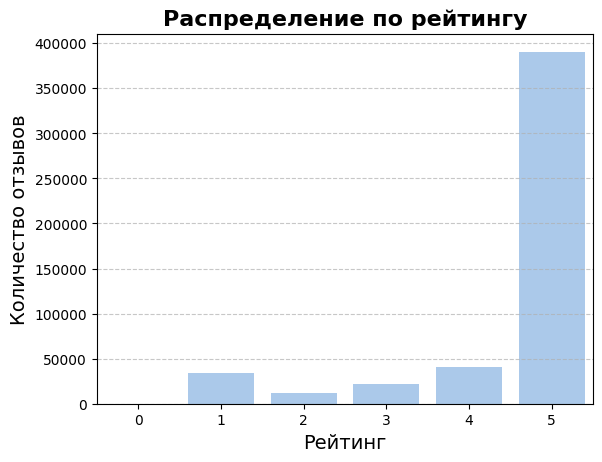

In [45]:
# Визуализация распределения классов
sns.set_palette("pastel")
sns.barplot(x=rating_distribution.index, y=rating_distribution.values)
plt.title('Распределение по рейтингу', fontsize=16, fontweight='bold')
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Количество отзывов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Можно сделать вывод. что наибольшее количество отзывов имеет рейтинг 5, а наименьшее - 2.

ИССЛЕДУЕМ ТЕКСТ

In [46]:
# Добавляем новый столбец, который содержит длину текста отзыва
df['text_length'] = df['text'].apply(len)

<ipython-input-54-e05b4c5a3e9a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='text_length', data=df, palette="Set2")


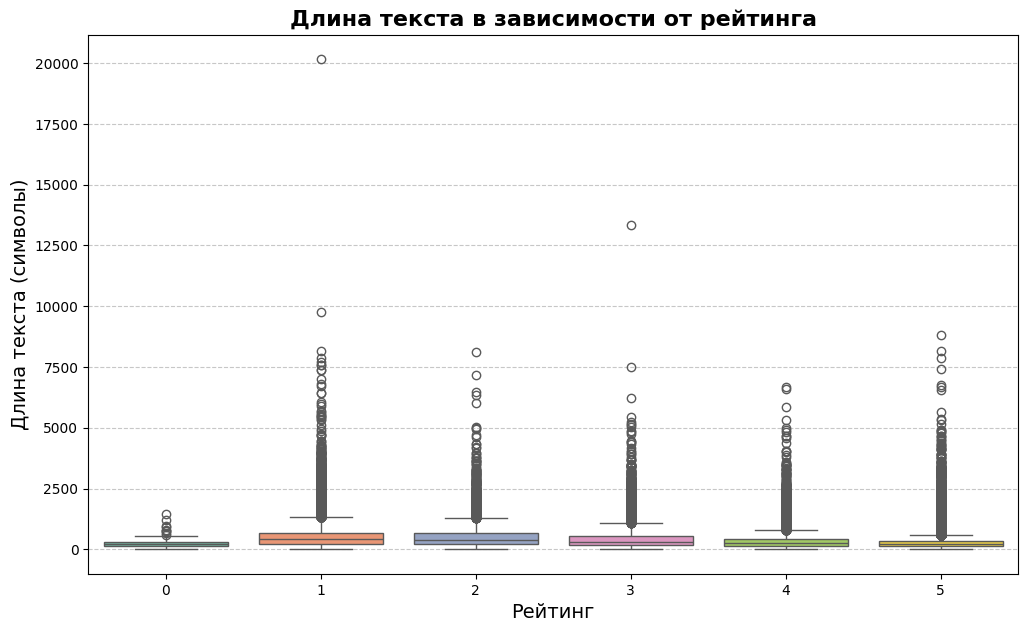

In [54]:
# Анализ зависимости длины текста от рейтинга
plt.figure(figsize=(12, 7))
sns.boxplot(x='rating', y='text_length', data=df, palette="Set2")
plt.title('Длина текста в зависимости от рейтинга', fontsize=16, fontweight='bold')
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Длина текста (символы)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Можно увидеть, как длина отзывов варьируется в зависимости от рейтинга, что может указывать на то, что пользователи, оставляющие либо самые низкие, либо самые высокие рейтинги, пишут более длинные отзывы.

In [55]:
# Извлекаем первые 50 записей для дальнейшего анализа
sample_data = df.head(50)

In [56]:
# Функция для получения длины слов из текста
def get_word_lengths(text):
    words = re.findall(r'\b\w+\b', text)  # Извлечение слов из текста
    return [len(word) for word in words]

In [57]:
# Сбор длины слов из текстового столбца
lengths_of_words = []
for review in sample_data['text']:
    lengths_of_words.extend(get_word_lengths(review))

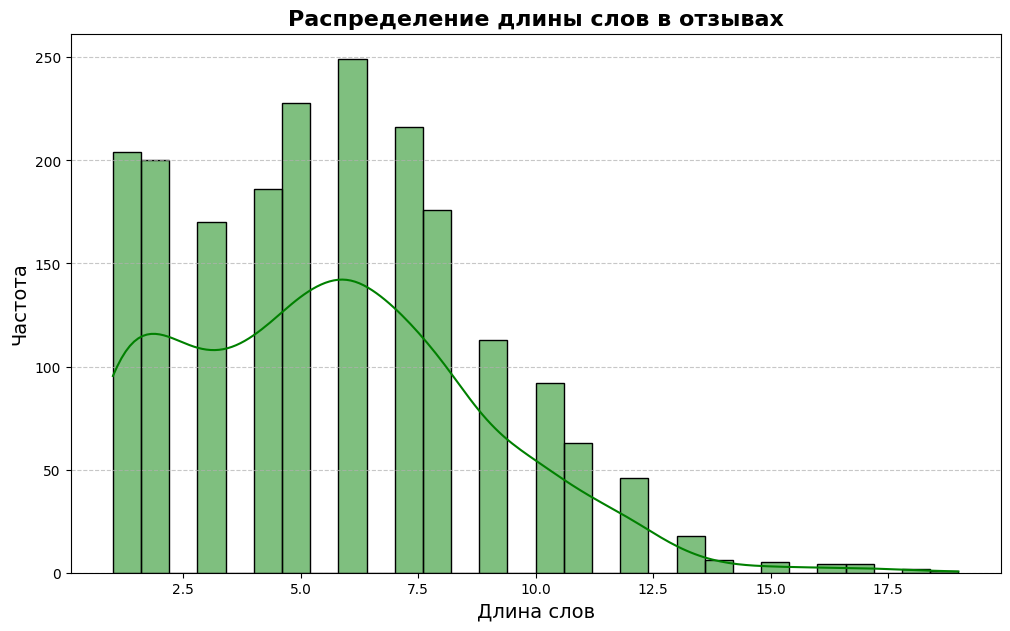

In [59]:
# Визуализируем распределения длины слов
plt.figure(figsize=(12, 7))
sns.histplot(lengths_of_words, bins=30, kde=True, color='green')
plt.title('Распределение длины слов в отзывах', fontsize=16, fontweight='bold')
plt.xlabel('Длина слов', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Длинные слова встречаются гораздо реже. Пользователи стараются употреблять более короткие слова.

In [61]:
# Используем данную функцию для извлечения уникальных слов
def find_unique_words(text_series):
    unique_set = set()
    for review in text_series:
        words = re.findall(r'\b\w+\b', review.lower())  # Извлекаем слова в нижнем регистре
        unique_set.update(words)
    return unique_set

unique_words_set = find_unique_words(sample_data['text']) # Получаем уникальные слова из текстов

count_unique_words = len(unique_words_set) # считаем их

print(f"Количество уникальных слов в 50 отзывах: {count_unique_words}")


Количество уникальных слов в 50 отзывах: 1196


Подготовка данных для дальнейшего анализа и определение самых часто встречаемых слов:

In [62]:
# Объединяем текстовые данные для анализа
combined_text = ' '.join(sample_data['text'].tolist())

In [65]:
# Функция для очистки текста и его токенизации
def clean_and_split_text(text):
    text = text.lower()  # Приведение текста к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    tokens = word_tokenize(text)  # Токенизация
    stop_words_set = set(stopwords.words('russian'))  # Установка стоп-слов
    tokens = [word for word in tokens if word not in stop_words_set]  # Фильтрация стоп-слов
    return tokens
tokens_cleaned = clean_and_split_text(combined_text) # Очистка и токенизация текста
word_frequency = Counter(tokens_cleaned) # Подсчет частоты появления слов
most_common_words = word_frequency.most_common(10) # Получение 10 самых частых слов

# Вывем наиболее частые слова
print("10 наиболее часто встречающихся слов:")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")

10 наиболее часто встречающихся слов:
очень: 37
это: 9
спасибо: 8
персонал: 7
качество: 6
всё: 6
место: 5
рекомендую: 5
большой: 4
время: 4


Посчитаем биграммы:

In [66]:
# Функция для подсчета фраз (n-грамм)
def find_top_phrases(tokens, n=2, top_n=10):
    n_grams = ngrams(tokens, n)
    phrase_count = Counter(n_grams)
    return phrase_count.most_common(top_n)

# Получение 10 самых частых биграмм
top_bigrams = find_top_phrases(tokens_cleaned, n=2)

# Выводим результат
print("\n10 наиболее часто встречающихся биграмм:")
for phrase, frequency in top_bigrams:
    print(f"{' '.join(phrase)}: {frequency}")



10 наиболее часто встречающихся биграмм:
удобное расположение: 3
цены приемлемые: 2
первый делала: 2
очень мало: 2
приятная атмосфера: 2
бесплатного материала: 2
очень довольна: 2
рекомендую посещению: 2
очень вкусно: 2
вежливый персонал: 2


АНАЛИЗ РАСПРЕДЕЛЕНИЯ СЛОВ В ЗАВИСИМОСТИ ОТ РЕЙТИНГА

In [67]:
# Функция для предобработки текста
def preprocess_review_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    tokens = word_tokenize(text)  # Токенизация
    stop_words_set = set(stopwords.words('russian'))  # Стоп-слова
    tokens = [word for word in tokens if word not in stop_words_set]  # Удаление стоп-слов
    return tokens

# Словарь для хранения частоты слов по рейтингам
word_frequency_by_rating = {}

In [68]:
# Обработка текстов и подсчет частоты слов по рейтингам
for idx, row in sample_data.iterrows():
    rating = row['rating']
    review_text = row['text']
    tokens = preprocess_review_text(review_text)

    if rating not in word_frequency_by_rating:
        word_frequency_by_rating[rating] = Counter()

    word_frequency_by_rating[rating].update(tokens)

ТОП-10 слов для рейтинга 1:
доверенности: 4
застройщик: 4
очень: 3
р: 3
говорят: 2
номер: 2
свои: 2
доставка: 2
своих: 2
это: 2



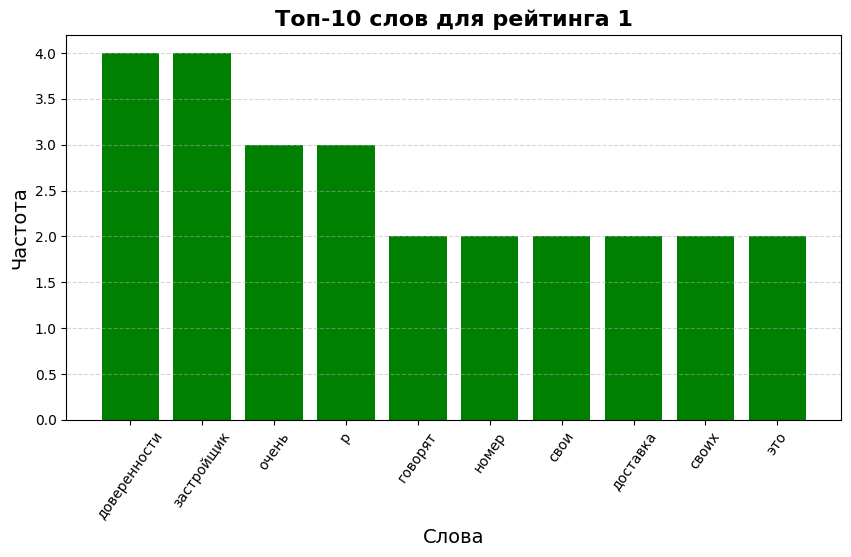

ТОП-10 слов для рейтинга 2:
хочется: 2
самый: 1
большой: 1
плюс: 1
это: 1
месторасположение: 1
набережная: 1
шикарный: 1
вид: 1
море: 1



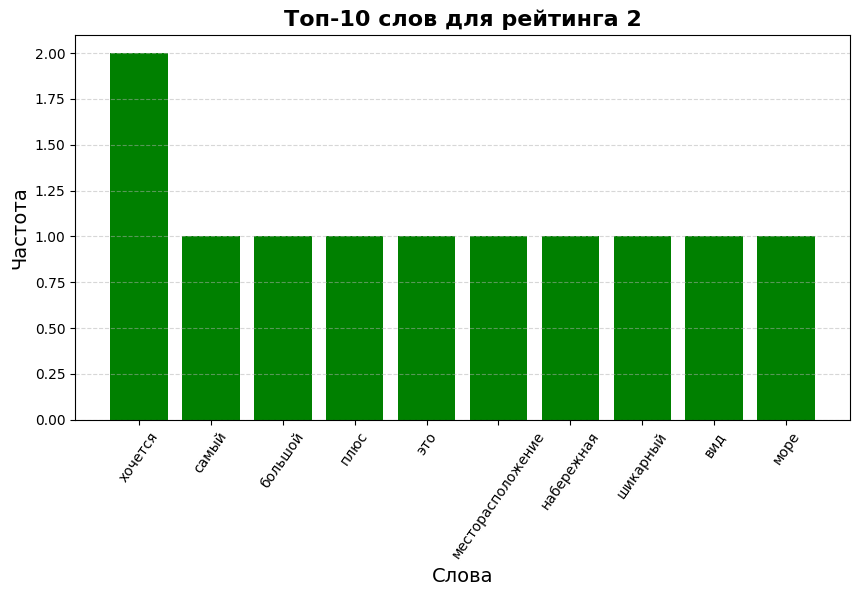

ТОП-10 слов для рейтинга 3:
пляж: 3
окна: 2
очень: 2
3: 2
рядом: 2
московский: 1
квартал: 1
2nшумно: 1
летом: 1
ночам: 1



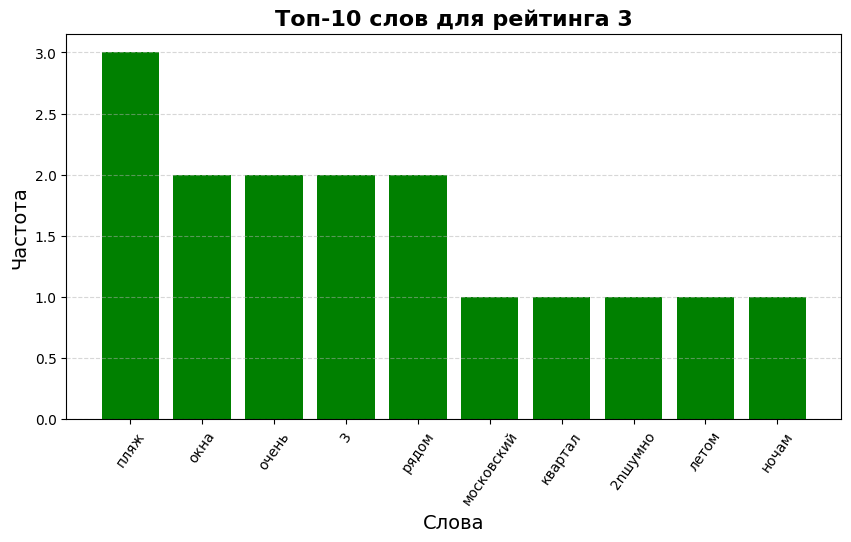

ТОП-10 слов для рейтинга 4:
очень: 4
мало: 2
хорошие: 1
условия: 1
аренды: 1
nдружелюбный: 1
персоналnно: 1
бывают: 1
неутоюбные: 1
ботинки: 1



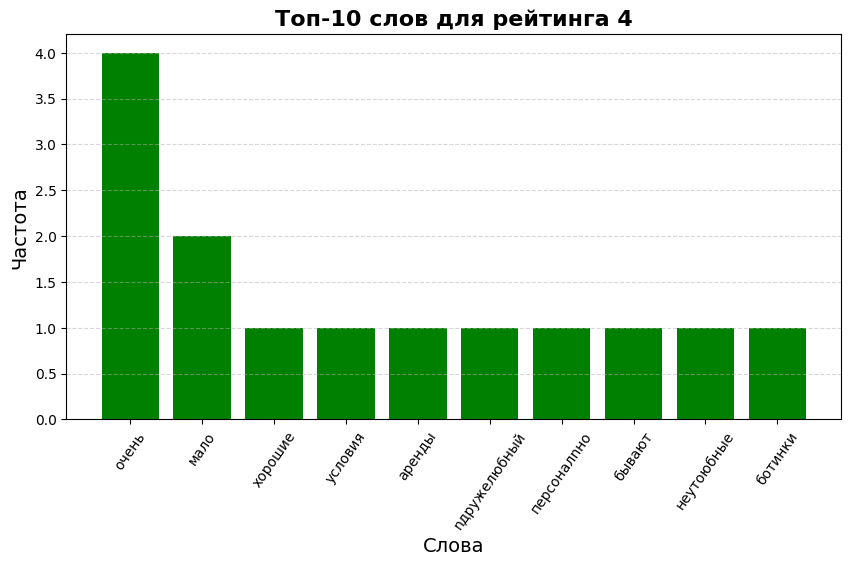

ТОП-10 слов для рейтинга 5:
очень: 28
спасибо: 8
персонал: 6
всё: 5
это: 5
хороший: 4
качество: 4
мастер: 4
понравилось: 4
место: 4



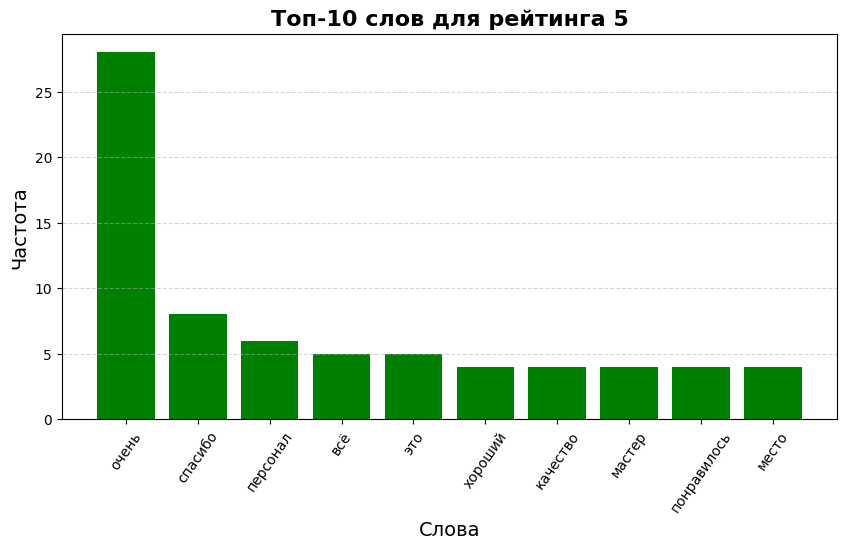

In [85]:
 #Визуализируем самые встречающиеся слова для каждого рейтинга
def visualize_top_words(freq_dict, top_n=10):
    # Сортируем рейтинги от 1 до 5
    for rating_val in sorted(freq_dict.keys()):
        counter = freq_dict[rating_val]
        print(f"ТОП-{top_n} слов для рейтинга {rating_val}:")
        top_words = counter.most_common(top_n)

        for word, freq in top_words:
            print(f"{word}: {freq}")
        print()

        words, frequencies = zip(*top_words)
        plt.figure(figsize=(10, 5))
        plt.bar(words, frequencies, color='green')
        plt.title(f'Топ-{top_n} слов для рейтинга {rating_val}', fontsize=16, fontweight='bold')
        plt.xlabel('Слова', fontsize=14)
        plt.ylabel('Частота', fontsize=14)
        plt.xticks(rotation=55)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()


visualize_top_words(word_frequency_by_rating)

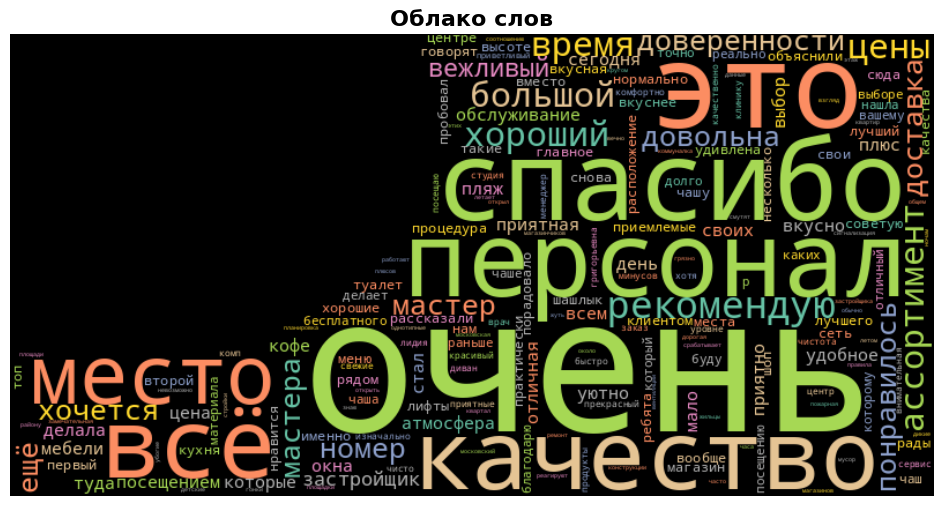

In [111]:
# Создаем овальной маски
def create_oval_mask(width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    y, x = np.ogrid[:height, :width]
    center_x, center_y = width // 8, height // 5
    radius_x, radius_y = width // 3, height // 2
    mask[(x - center_x) ** 2 / radius_x ** 2 + (y - center_y) ** 2 / radius_y ** 2 <= 1] = 255
    return mask

# Задаем размеры маски
mask = create_oval_mask(800, 400)

# Создаем облако слов
all_reviews_text = ' '.join(sample_data['text'].tolist())

# Функция для предобработки текста
def prepare_text_for_wordcloud(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words_set = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words_set]
    return ' '.join(tokens)

# Предобработка текста
cleaned_reviews_text = prepare_text_for_wordcloud(all_reviews_text)

# Создаем облака слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color=None,
    mode='RGB',
    colormap='Set2',
    contour_color='black',
    contour_width=1,
    mask=mask,
    random_state=42
).generate(cleaned_reviews_text)

# Визуализируем облако слов
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов', fontsize=16, fontweight='bold')
plt.show()